# 【大语言模型系列】提升RAG质量的方法二（实践篇）信息融合

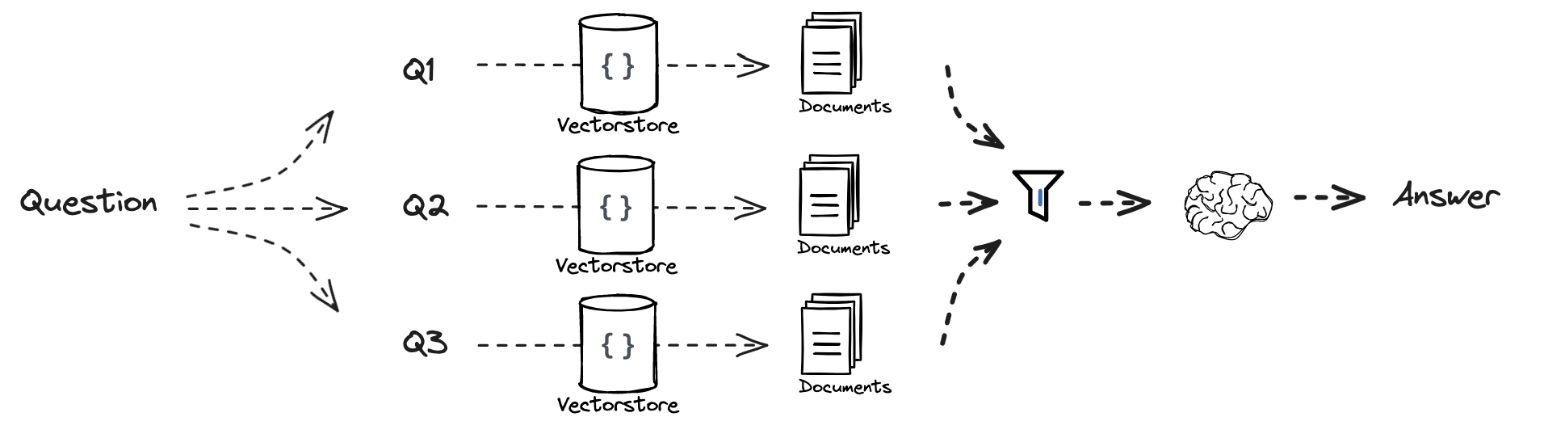

Docs:
* https://github.com/langchain-ai/langchain/blob/master/cookbook/rag_fusion.ipynb?ref=blog.langchain.dev
Blog / repo: 
* https://towardsdatascience.com/forget-rag-the-future-is-rag-fusion-1147298d8ad1
图片来源：
* 【🔥 从零开始学习 RAG｜2️⃣ 优化原始提问】 https://www.bilibili.com/video/BV1QE421L7qe/?share_source=copy_web&vd_source=f65342ebbf0b68f07ba0fc6772b947f7
* Bilibili @沧海九粟

## 1.1 环境导入

In [4]:
from dotenv import load_dotenv
load_dotenv()

import os
os.environ['http_proxy'] = os.getenv("http_proxy")
os.environ['https_proxy'] = os.getenv("https_proxy")

os.environ["LANGCHAIN_TRACING_V2"] = os.getenv("LANGCHAIN_TRACING_V2")
os.environ["LANGCHAIN_API_KEY"] = os.getenv("LANGCHAIN_API_KEY")

os.environ["DASHSCOPE_API_KEY"] = os.getenv("DASHSCOPE_API_KEY")

## 1.2 加载数据

In [5]:
from langchain.document_loaders import TextLoader, DirectoryLoader

home_path = os.getcwd()
data_path = os.path.join(home_path, 'data')
text_loader_kwargs ={'autodetect_encoding': True}
loader = DirectoryLoader(data_path, glob="**/*.txt", loader_cls=TextLoader, loader_kwargs=text_loader_kwargs, show_progress=True)
docs = loader.load()

100%|██████████| 8/8 [00:00<00:00, 1601.26it/s]


## 1.3 建立向量数据库

In [6]:
from langchain_community.embeddings import DashScopeEmbeddings
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.vectorstores import Chroma


text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200)
documents = text_splitter.split_documents(docs)
db = Chroma.from_documents(documents, DashScopeEmbeddings())

## 1.4 建立第一条链——问题ReWrite

In [7]:
from langchain.prompts import ChatPromptTemplate

# RAG-Fusion: Related
template = """You are a helpful assistant that generates multiple search queries based on a single input query. \n
Generate multiple search queries related to: {question} \n
Output (4 queries):"""
prompt_rag_fusion = ChatPromptTemplate.from_template(template)

In [8]:
from langchain_core.output_parsers import StrOutputParser
from langchain_community.chat_models import ChatTongyi

generate_queries = (
    prompt_rag_fusion 
    | ChatTongyi(temperature=0)
    | StrOutputParser() 
    | (lambda x: x.split("\n"))
)

## 1.4 建立第二条链——检索档案排名

In [11]:
from langchain.load import dumps, loads

def reciprocal_rank_fusion(results: list[list], k=60):
    """ Reciprocal_rank_fusion that takes multiple lists of ranked documents 
        and an optional parameter k used in the RRF formula """
    
    # Initialize a dictionary to hold fused scores for each unique document
    fused_scores = {}

    # Iterate through each list of ranked documents
    for docs in results:
        # Iterate through each document in the list, with its rank (position in the list)
        for rank, doc in enumerate(docs):
            # Convert the document to a string format to use as a key (assumes documents can be serialized to JSON)
            doc_str = dumps(doc)
            # If the document is not yet in the fused_scores dictionary, add it with an initial score of 0
            if doc_str not in fused_scores:
                fused_scores[doc_str] = 0
            # Retrieve the current score of the document, if any
            previous_score = fused_scores[doc_str]
            # Update the score of the document using the RRF formula: 1 / (rank + k)
            fused_scores[doc_str] += 1 / (rank + k)

    # Sort the documents based on their fused scores in descending order to get the final reranked results
    reranked_results = [
        (loads(doc), score)
        for doc, score in sorted(fused_scores.items(), key=lambda x: x[1], reverse=True)
    ]

    # Return the reranked results as a list of tuples, each containing the document and its fused score
    return reranked_results

retriever = db.as_retriever()
retrieval_chain_rag_fusion = generate_queries | retriever.map() | reciprocal_rank_fusion
# docs = retrieval_chain_rag_fusion.invoke({"question": question})
# len(docs)

## 1.4 建立第三条链——问答

In [13]:
from langchain_core.runnables import RunnablePassthrough
from operator import itemgetter

# RAG
template = """Answer the following question based on this context:

{context}

Question: {question}
"""

prompt = ChatPromptTemplate.from_template(template)

llm = ChatTongyi(temperature=0)

final_rag_chain = (
    {"context": retrieval_chain_rag_fusion, 
     "question": itemgetter("question")} 
    | prompt
    | llm
    | StrOutputParser()
)

question = "What is task decomposition for LLM agents?"

final_rag_chain.invoke({"question":question})

C:\Users\Administrator\AppData\Local\Temp\ipykernel_17864\10616765.py:26: LangChainBetaWarning: The function `loads` is in beta. It is actively being worked on, so the API may change.
  (loads(doc), score)


'The provided context does not explicitly mention "task decomposition for LLM agents." However, it does discuss how large language models (LLMs) are being developed and utilized as intelligent agents to perform complex retrieval tasks. \n\nFrom the context, we can infer that one approach to task handling by LLMs involves breaking down tasks into smaller, manageable parts, such as:\n\n1. **Combining Retrieval and Answering:** Some researchers explore integrating the retrieval and answering processes within LLMs to improve performance. This can be seen as a form of task decomposition where the model handles both retrieving relevant information and generating accurate responses.\n\n2. **Autonomous Searching and Synthesizing:** LLMs as intelligent agents are empowered to autonomously search, interpret, and synthesize information from various sources. This indicates that they can handle multiple sub-tasks independently, such as searching for relevant documents and synthesizing the most pert